# Access and analyze seismograms

_This notebook was created by Léonard Seydoux (seydoux@ipgp.fr) in 2022 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr)._ 

<img width=200px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png" />

## Table of contents

1. [Introduction](#1.-Introduction)
    1. [Goals](#1.1.-Goals)
    2. [Requirements](#1.2.-Requirements)
    3. [Searching events of interest](#1.3.-Searching-events-of-interest)
2. [Seismic waveforms](#2.-Seismic-waveforms)
    1. [Downloading seismic waveforms](#2.1.-Downloading-seismic-waveforms)
    2. [Inspection of the metadata](#2.2.-Inspection-of-the-metadata)
    3. [Inspection of the waveform](#2.3.-Inspection-of-the-waveform)
    4. [Saving and reading waveforms locally](#2.4.-Saving-and-reading-waveforms-locally)
    5. [Instrument response correction](#2.5.-Instrument-response-correction)
3. [Spectral analysis](#3.-Spectral-analysis)
    1. [Fourier transform](#3.1.-Fourier-transform)
    2. [Filtering](#3.2.-Filtering)
    3. [Spectrogram](#3.3.-Spectrogram)
4. [Analysis with a selected event](#4.-Analysis-with-a-selected-event)


## 1. Introduction

### 1.1. Goals

This notebook shows how to download, plot, and analyze seismic waveforms in time and frequency. It goes from identifying events of interest by exploring online resources with reported events to extracting the seismic waveforms from suited data centers and analyzing their properties. 

### 1.2. Requirements

This notebook relies on Python libraries listed below. If you are running this notebook on the virtual machine provided for the course, you should have all the required libraries installed. If you are running this notebook on your own machine, you will need to install the following libraries:

- [ObsPy](https://github.com/obspy/obspy/wiki), an open-source project that provides a Python framework for processing seismological data. It provides parsers for standard file formats, clients to access data centers, and signal processing routines that allow the manipulation of seismological time series.
- [NumPy](https://numpy.org), an open-source project aiming to enable numerical computing with Python.
- [SciPy](https://numpy.org), fundamental algorithms for scientific computing in Python.
- [Matplotlib](https://matplotlib.org), a comprehensive library for creating static, animated, and interactive visualizations in Python.

If unavailable on your machine, you can use the [Anaconda](https://www.anaconda.com) package manager to install these libraries. Please ensure you can run the following cell without any error before proceeding further.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import obspy 
from obspy.clients.fdsn import Client
from obspy.geodetics import locations2degrees
from scipy.signal import spectrogram

### 1.3. Searching datasets of interest

#### Motivations

Looking for seismic data is generally motivated by a scientific question or by curiosity to look at some recent events. Here we deliver the sources where this information is accessible. You may also find crucial information from other regional and national earthquake information services (volcano observatories, glacial area observatories).

- The [United States Geological Survey (USGS) Advanced National Seismic System Comprehensive Catalog of Earthquakes Events and Products](https://earthquake.usgs.gov/earthquakes/search) provides one of the most comprehensive global earthquake catalogs. It delivers earthquake source parameters (e.g. hypocenters, magnitudes, phase picks, and amplitudes) and other products (e.g. moment tensor solutions, macroseismic information, tectonic summaries, maps) produced by contributing seismic networks. The webpage https://earthquake.usgs.gov/data/comcat/ provides a list of contributing seismic networks.
- The [ISC-GEM Global Instrumental Earthquake Catalogue](http://www.isc.ac.uk/iscbulletin/search/catalogue/) (1904-2018) is the result of a special effort to adapt and substantially extend and improve currently existing bulletin data for large earthquakes (magnitude 5.5 and above, plus continental events down to magnitude 5.0) to serve the requirements of the specific user group who assess and model seismic hazard and risk.
- The [European-Mediterranean Seismological Centre (EMSC), France](https://www.emsc-csem.org) was founded in 1975, following a recommendation from the European Seismological Commission (ESC). The ESC is a regional commission of the International Association of Seismology and Physics of the Earth's Interior (IASPEI), itself a specialized association of the International Union of Geodesy and Geophysics (IUGG).

#### Sensors

Seismic stations or networks are also listed in several websites. The [International Federation of Digital Seismograph Networks (FDSN)](https://www.fdsn.org/about/) goals related to station siting and instrumentation are to provide stations with good geographic distribution, recording data with 24 bits of resolution in continuous time series with at least a 20 sample per second sampling rate. You can find a [list of seismic networks with links to station maps and descriptions](https://www.fdsn.org/networks/) online to fetch seismic data on specific regions and temporal coverage. Also, the [Incorporated Research Institutions for Seismology (IRIS)](https://ds.iris.edu/gmap/) is a consortium of universities dedicated to the operation of science facilities for the acquisition, management, and distribution of seismological data. IRIS delivers seismic waveforms and metadata based on the FDSN inventory, which facilitates the [search of the temporary or permanent seismic network](https://ds.iris.edu/gmap/). Here are some famous ones:

- [IU, the Global Seismograph Network (GSN) operated by IRIS and USGS](https://www.fdsn.org/networks/detail/IU/), described by a global distribution of high-gain, co-located broadband velocity instruments and accelerometers.
- [II, the Global Seismograph Network (GNS) operated by IRIS and IDA](https://www.fdsn.org/networks/detail/II/).
- [G, GEOSCOPE](https://www.fdsn.org/networks/detail/G/) is a global seismological network created in 1982 to respond to the challenge of instrumenting isolated sites all around the world. More information is available at the [Institut de Physique du Globe de Paris website](http://geoscope.ipgp.fr/index.php/en/stations/station-map).
- [FR: RESIF](https://www.fdsn.org/networks/detail/FR/) and other broadband and permanent accelerometric networks in metropolitan France allow monitoring of the seismicity in metropolitan France and the development of seismic risk and hazards maps.
- [PF: Piton de la Fournaise Volcano Observatory Network (Reunion Island)](https://www.fdsn.org/networks/detail/PF/) allows monitoring of the volcano-seismic activity of the Piton de la Fournaise volcano. 
- [GL: Guadeloupe Seismic and Volcano Observatory Network](https://www.fdsn.org/networks/detail/GL/) allows monitoring of the volcano-seismic activity of La Soufrière volcano. 
- [HV: Hawaiian Volcano Observatory Network](https://www.fdsn.org/networks/detail/HV/) allows monitoring of the volcano-seismic activity in Hawaii. 
- [TA: USArray Transportable Array](https://www.fdsn.org/networks/detail/TA/) is a transportable array that was deployed between 2004 and 2019 in the US.

#### Data centers

Finally, a comprehensive list of datacentersthat support the FDSN webservices can be found at https://www.fdsn.org/webservices/datacenters/. Among others, you can find here a shortlist of international and French data centers:
- [IRIS Data Management Center](https://ds.iris.edu/ds/nodes/dmc/)
- [EIDA: European Integrated Data Archive](http://www.orfeus-eu.org/data/eida/)
- [RESIF: French seismological and geodetic network](http://seismology.resif.fr)
- [IPGP: data center of the Institut de Physique du Globe de Paris](http://datacenter.ipgp.fr/data.php)

## 2. Seismic waveforms

### 2.1. Downloading seismic waveforms

Several tools allow downloading seismic waveforms provided by the datacenters via the [FDSN Web Services](https://www.fdsn.org/webservices/) which is [natively included in the obspy Python library](https://docs.obspy.org/packages/obspy.clients.fdsn.html). Here we show an example of how to download seismic data from the IRIS datacenter with the `Client` interface of `obspy`. Once the interface is connected to a client of interest, we can request a seismic waveform by specifying several metadata such as the network code, the station code, the location of the sensor in the station, the channel name, the start and end datetimes, and other information. Please check the [documentation of the `get_waveform` method](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html).

Seismic records are organized in a specific type of object in Python called a `trace`. Since several traces can be downloaded at once, several traces are gathered into a `stream` object. By default, the `get_waveform` method returns a `stream` event if only one trace was downloaded. You can print a succinct amount of information about the stream with the `print` function.

> __Question 1.__ What kind of seismic network is the IU network (global, local)? Where is the seismic station CTAO located? From the date and time used in the above example waveform query, which earthquake was recorded by the seismic sensor CTAO? What is the approximate epicentral distance of the earthquake to the seismic station? Please use the different websites provided in the previous section together with the obspy documentation to answer that question. You can also use the obspy method [`location2degrees`](https://docs.obspy.org/packages/autogen/obspy.geodetics.base.locations2degrees.html) to answer the last question.

In [2]:
# Connect to IRIS
client = Client("IRIS")

# Get the data
stream = client.get_waveforms(
    network="IU",
    station="CTAO",
    location="*",
    channel="BHZ",
    starttime=obspy.UTCDateTime("2021-03-04T19:28:33"),
    endtime=obspy.UTCDateTime("2021-03-04T21:30:00"),
    attach_response=True,
)

# Print the content of the stream
print(stream)

2 Trace(s) in Stream:
IU.CTAO.00.BHZ | 2021-03-04T19:28:33.019538Z - 2021-03-04T21:29:59.994538Z | 40.0 Hz, 291480 samples
IU.CTAO.10.BHZ | 2021-03-04T19:28:33.019538Z - 2021-03-04T21:29:59.994538Z | 40.0 Hz, 291480 samples


In [3]:
# Your code goes here to answer question 1

### 2.2. Inspection of the metadata

A `stream` can be seen as a list (actually, an iterable) of `trace` objects, plus methods. More precisely, almost all of the methods available in a `trace` object is available in a `stream` object, to be applied on all traces individually. In the following examples, we will narrow the focus on the first trace of the downloaded stream, and take a look at its metadata. A trace's metadata are stored in a dictionnary named `stats`. The entries of this dictionnary may depend on the format of the seismic trace. The most common seismic formats are `SAC` and `MSEED` (visible in the `_format` entry of the `stats` dictionnary).

> __Question 2.__ Take time to discover the `stats` dictionnary of a selected `trace` and understand the different entries. More information about this dictionnary can be found in the [obspy documentation](https://docs.obspy.org/packages/autogen/obspy.core.trace.Stats.html). In particular, what are the `npts`, `delta` and `sampling_rate` entries? Please define everything with respect to the digital signal $u[n] = u(n\Delta t)$ and other quantities seen during the class. In which format was the trace downloaded? Considering the online [documentation about the data formats on IRIS](http://ds.iris.edu/ds/nodes/dmc/data/formats/), what does `number_of_records` mean in that case? What information is presented in the `response` entry? What is the signification of a sensor sensitivity? 

In [4]:
# Your code goes here

### 1.3. Inspection of the waveform

In the following example, we define a time vector in number of samples $t = 0\ldots N$. Modify the cell below to turn this time vectors into a relative time (in seconds) from the begining of the record based on the entries of the `stats` dictionary, and update the x-axis name accordingly. 

> __Question 3.__ How would you proceed to use an absolute time array with date ticks? What is the type and unit of the raw `data`? Please name the axis accordingly, and explain your answer. What would you need to turn the waveform into physical units? Modify the code below to name the axes.

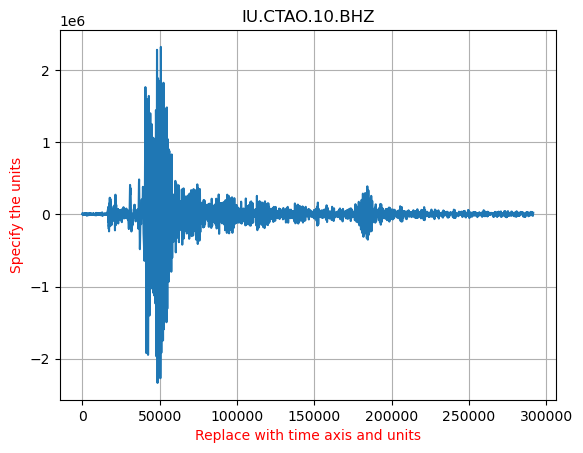

In [5]:
# Select a seismic trace
trace = stream[1]

# Waveform data
waveform = trace.data

# Plot
fig, ax = plt.subplots()
ax.plot(waveform)

# Axes
ax.set_xlabel("Replace with time axis and units", color="red")
ax.set_ylabel("Specify the units", color="red")
ax.set_title(trace.id)
ax.grid()

# Show
plt.show()

### 1.4. Saving and reading waveforms locally

Of course, in order to avoid re-downloading the waveforms everytime, one should be able to write it down to a local or remote disk. This can be achieved at the `stream` or the `trace` level. Here again, you can decide the format you would like to use. You can look at the specificities of every format in the documentation. Then, local waveforms can be loaded directly in with the `obspy.read` method. This method allows to read almost all existing seismic data formats. Once the previous cell was ran, you can execute the next cell to read back the data.

> __Question 4.__ Use the code below to save the seismogram locally. Change the format between SAC and MSEED. What main differences exist between these two formats? Load the locally-saved stream from MSEED format. What missing in the trace metadata after reading?

In [6]:
# Write
stream.write(filename="seismogram.sac")

# Read the saved stream below into a new stream and explore its metadata
# (compare with the original stream)
stream_sac = obspy.read("seismogram01.sac")

### 1.5. Instrument response correction

For a physical interpretation of the waveform amplitude, we need to convert the raw waveforms into physical units such as ground displacement, velocity, or acceleration. Because we asked the program to _attach the response_ in the `get_waveform` method, we can use the `trace.remove_response()` method to remove the instrument response. Please check the documentation to understand how this method works.

> __Question 5.__ Why do we need for such a complete tool to remove the instrument response, and why don't we simply infer how many velocity is 1 count, and divide the counts by this value? Add code to the cell below to show the corrected waveform. What changed compared with the raw waveform? We can use a `pre_filt` tuple that defines a bandpass filter in frequency domain to the data before deconvolution. The list or tuple defines the four corner frequencies (f1, f2, f3, f4) of a cosine taper which is one between f2 and f3 and tapers to zero for f1 < f < f2 and f3 < f < f4. Can you use this filter to remove the very-low-frequency signature? Plot the displacement $u[n]$, velocity $\dot u[n]$, and acceleration $\ddot u[n]$ on three separate subplots. What are the main differences between the signals?

In [7]:
# Prefilter, remove response and get physical units
filter_frequencies = 0.01, 0.015, 15, 20

# Loop over the units
units = {
    "ACC": "$\ddot u(t)$ in $m/s^2$",
    "VEL": "$\dot u(t)$ in $m/s$",
    "DISP": "$u(t)$ in $m$",
}
for index, (unit_name, unit_desc) in enumerate(units.items()):
    # Remove response
    trace_physical = trace.copy()
    trace_physical.remove_response(
        output=unit_name, pre_filt=filter_frequencies
    )

    # Perform the plot below
    times = trace_physical.times()
    waveform_physical = trace_physical.data

## 3. Spectral analysis

### 3.1. Fourier transform

The time-domain representation of a waveform gives information about the temporal evolution of the rupture, the different kinds of seismic phases recorded, etc. Another critical tool of the seismologist is to observe the waveform's properties as a function of frequency. The Fourier transform is the most robust and stable tool to calculate the waveform's spectrum. Note that many other transforms allow visualizing the spectral properties of signals against frequencies. Other methods exist because of the robustness to noise, capability to be applied on very-short duration time series, or other specificities.

> __Question 6.__ Use the `numpy.fft` module to calculate the Fourier spectrum $\hat u(f)$ of the seismic trace $u[n]$ in the cell below. Withing several subplots, show the raw, displacement, velocity, and acceleration spectrum $|\hat u(f)|$  in a log-log scale. What is the effect of the pre-filter in every case? Give a very simple interpretation of the observed spectra: where is the energy located for each physical unit?

In [8]:
# Your code goes here

### 3.2. Filtering

Thanks to digital processing tools, it is possible to filter out the waveform content within specific frequency bands. The cell below shows how to filter the seismic signal in a band of interest.

> __Question 7.__  Show the filtered trace in both time and frequency domains. What is the effect of the filter? Using a low-pass filter below 0.1 Hz, what features of the waveform do you better highlight? And with a high-pass filter above 2 Hz? By playing with the `corner` value in the filter above, how do you better select the frequencies of interest?

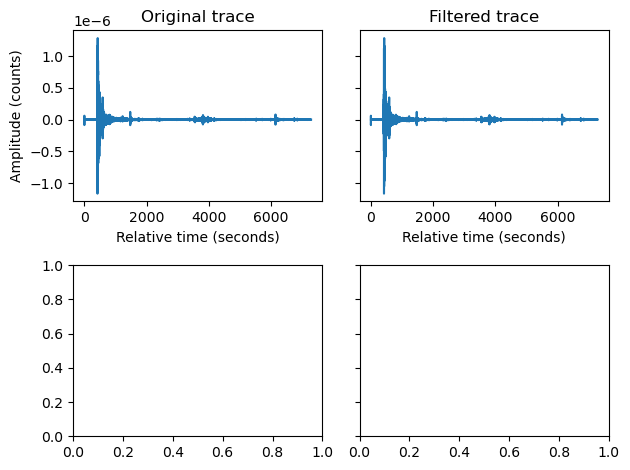

In [9]:
# Copy the data
trace_filter = trace_physical.copy()

# Filter
trace_filter.filter("bandpass", freqmin=1, freqmax=3, corners=4)

# Spectrum
spectrum_filter = np.fft.rfft(trace_filter.data)

# Plot
fig, ax = plt.subplots(2, 2, sharey="row")

# Plot the original trace
ax[0, 0].plot(trace_filter.times(), trace_filter.data)
ax[0, 0].set_ylabel("Amplitude (counts)")
ax[0, 1].plot(trace_filter.times(), trace_filter.data)

# Plot the spectrum
# Your code goes here

# Labels
ax[0, 0].set_xlabel("Relative time (seconds)")
ax[0, 1].set_xlabel("Relative time (seconds)")
ax[0, 0].set_title("Original trace")
ax[0, 1].set_title("Filtered trace")

# Show
plt.tight_layout()
plt.show()

### 3.3. Spectrogram

> __Question 8.__ The following cell performs a spectrogram —a time-dependant Fourier spectrum analysis $|\tilde u(f, t)|$— of the raw trace. What are the `nperseg` and the `noverlap` parameters useful for? Describe at least four different signal patterns seen in the spectrogram, depending on their duration, frequency bandwidth, etc. Two waves exhibit a typical signature in the spectrogram, with an increasing frequency against time. What does this imply for the speed of the seismic waves? How does this spectrogram changes with respect to the input waveform units?

In [10]:
# Extract waveform
waveform = trace.data
times = trace.times()

# Calculate spectrogram
frequencies, spectrogram_times, psd = spectrogram(
    waveform, fs=trace.stats.sampling_rate, nperseg=4000, noverlap=2500
)

# What's next?

## 4. Analysis with a selected event.

The time has come. Re-run the entire notebook with a event of your choice. Motivate your choice and anwser most of the questions with the new event.